# Tutorial 11

# EE19BTECH11051 - Pranav Kumar Kota

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io # to load matfiles
from scipy.io import loadmat
import cvxpy as cp


## Extract data from mat file

Data can be found 
<a href="https://github.com/KPK101/Convex_Optimisation/blob/main/Tutorial_11/sp_ln_sp_data_v5.mat" title="Wikipedia">here</a>

In [2]:
# Load data from saved mat file
matdir = 'sp_ln_sp_data_v5.mat' # file directory 
mat = loadmat(matdir)

# Extract data
M = int(mat['M'])
n = int(mat['n'])
N = int(mat['N'])
X = mat['X']
Y = mat['Y']

## L1 Regularisation for downsizing feature space 
L1 regularisation promotes sparsity of the parameter vector (a, in this case). Therefore, it results in redundancy in input data, as the features corresponding to the indices with value as 0 have no effect on the optimisation problem

In [3]:
lamda = np.logspace(-6,5,100)
    
def card(a): # return card(a)
    numcard = 0
    a = a.reshape(-1,1)
    for i in range(a.size):
        if(a[i]>1e-04):
            numcard += 1
    return numcard

def cardvec(a): # returns vector with 1's at index of non-zero values in a
    shape = np.shape(a.reshape(-1,1))
    aa = np.zeros(shape)
    for i in range(shape[0]):
        if(a[i]>1e-04):
            aa[i] = 1
    return aa

def norm(a): # 2 norm of the input vector
    return np.sqrt(sum(a*a))

def optimize_a(lamda,X,Y):
    
    # size parameters
    n = X.shape[0]
    N = X.shape[1]
    M = Y.shape[1]

    numlam = lamda.size
    slabThickness = np.zeros(numlam)
    card_a = np.zeros(numlam)
    card_vec = np.zeros((numlam,n))

    # Looping over lambda
    for i in range(numlam): # loop to compute cardinality and min_norm2 a
        
        l = lamda[i]
        a = cp.Variable((n,1))
        b = cp.Variable(1)
        
        # Defining the optimization problem
        objective = cp.Minimize(cp.norm(a,2) + l*cp.norm(a,1))
        constraints  = [cp.transpose(a)@X - cp.multiply(b,np.ones((1,N))) >= 1]
        constraints += [cp.transpose(a)@Y - cp.multiply(b,np.ones((1,M))) <= -1]
        prob = cp.Problem(objective,constraints)
        result = prob.solve()
        
        # Result for each lambda
        slabThickness[i] = 2./norm(a.value)
        card_a[i] = card(a.value)
        card_vec[i] = cardvec(a.value).reshape(1,-1)
        
    return slabThickness,card_vec,card_a

[slabThickness,card_vec,card_a] = optimize_a(lamda,X,Y)

 ## Comparing slab thickness and cardinality of a

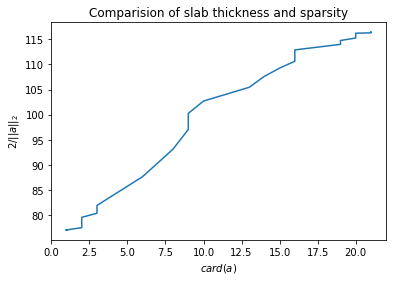

In [4]:
plt.plot(card_a,slabThickness)
plt.title("Comparision of slab thickness and sparsity")
plt.xlabel("$card(a)$")
plt.ylabel("$2/||a||_2$")
plt.show()

We need a solution with a thick seperating slab for more robust classification.
On the other hand, we also need more sparsity to have lesser number of features, but we don't want extreme downsizing as it will lead to loss of useful information.
Therefore, we choose a pair in the centre.

In [5]:
print(f"Maximum thickness of seperating slab = {max(slabThickness)}")

Maximum thickness of seperating slab = 116.42440503377907


In [6]:
# Choosing lamda[50] as the optimal lambda
optindex = 50
print(f"For the chosen value of lambda:\nCardinality is {card_a[optindex]}")
print(f"Slab thickness is {slabThickness[optindex]}")
print(f"The carinality vector for chosen lambda is:\n{card_vec[optindex]}")

For the chosen value of lambda:
Cardinality is 13.0
Slab thickness is 105.44936132614993
The carinality vector for chosen lambda is:
[1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 1.]


## Optimal solution for chosen features

We choose 10 features corresponding to ones in the cardinality vector for the optimum index

In [7]:

X_downsize = np.vstack((X[:2,:],X[3,:],X[8,:],X[10:13,:],X[24,:],X[33,:],X[37,:]))
Y_downsize = np.vstack((Y[:2,:],X[3,:],Y[8,:],Y[10:13,:],Y[24,:],Y[33,:],Y[37,:]))

NN = X_downsize.shape[1]
MM = Y_downsize.shape[1]

a = cp.Variable((10,1))
b = cp.Variable(1)

objective = cp.Minimize(cp.norm(a,2))
constraints  = [cp.transpose(a)@X_downsize - cp.multiply(b,np.ones((1,NN))) >= 1]
constraints += [cp.transpose(a)@Y_downsize - cp.multiply(b,np.ones((1,MM))) <= -1]
prob = cp.Problem(objective,constraints)
result = prob.solve()

opt_norm = result
opt_card = card(a.value)

In [8]:
print(f"Optimal slab thickness is {opt_norm}")
print(f"Optimal cardinality is {opt_card}")

Optimal slab thickness is 0.052244935843155406
Optimal cardinality is 10
